# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
### Imports:

from tensorflow.contrib.layers import flatten
import pickle
import numpy as np
import cv2
import random
import tensorflow as tf
from sklearn.utils import shuffle
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.interactive(True)

### Constants (in caps):

TRAINING_FILE = '../traffic-signs-data/train.p'   ### path to the provided training file.
VALIDATION_FILE = '../traffic-signs-data/valid.p' ### path to the provided validation file.
TESTING_FILE = '../traffic-signs-data/test.p'     ### path to the provided test file.
SIGNNAMES_FILE = 'signnames.csv'                  ### path to the signnames files (class vs name).
EPOCHS = 10                                       ### number of epochs during training.
BATCH_SIZE = 512                                  ### batch size during training.
MU = 0                                            ### mean for the weights in the convolutional and fully connected layers.
SIGMA = 0.1                                       ### std dev for the weights in the convolutional and fully connected layers.
RATE = 0.002                                      ### learning rate.
CHANNELS = 1                                      ### depth of the training-validation-test images (1 for gray, 3 for color).
SAVED_MODEL = 'saved/trained_model'               ### path to where the results of training are saved. 
DATASET_DISPLAY = 5                               ### subplots for the visualization of the database.
SCREENSIZE = (16, 8.5)                            ### in inches of my screen.
KEEP_PROB = 0.7                                   ### keep probability for the dropout.
NEW_IMS_DIR = 'german_web_images/set_all'         ### where the new images (from the web) are stored.

### Class to determine execution times (in our case for the training of the CNN):

class TimeExecution():                            
    from datetime import datetime
    def __enter__(self):
        self.start = self.datetime.now()
    def __exit__(self, *args, **kwargs):
        print('Runtime: {}'.format(self.datetime.now() - self.start))


In [2]:
### Load the database:

with open(TRAINING_FILE, mode='rb') as f:
    train = pickle.load(f)
with open(VALIDATION_FILE, mode='rb') as f:
    valid = pickle.load(f)
with open(TESTING_FILE, mode='rb') as f:
    test = pickle.load(f)

### And select the keys we're interested in (features and labels): 

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### Duplicate the training, valid and test arrays for database visualization purposes
### (keep an "original" version to have access to the 'raw' images):

X_train_original = X_train
X_valid_original = X_valid
X_test_original = X_test

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Number of training examples.
n_train = len(X_train)

### Number of validation examples.
n_validation = len(X_valid)

### Number of testing examples.
n_test = len(X_test)

### What's the shape of an traffic sign image?
image_shape = X_train[0].shape

### How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(np.concatenate((y_train, y_valid, y_test), axis=0)))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

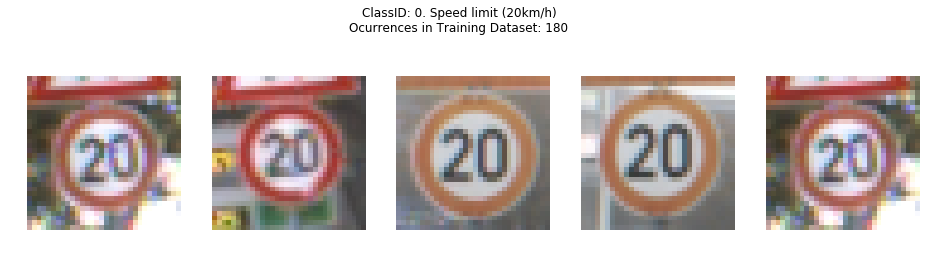

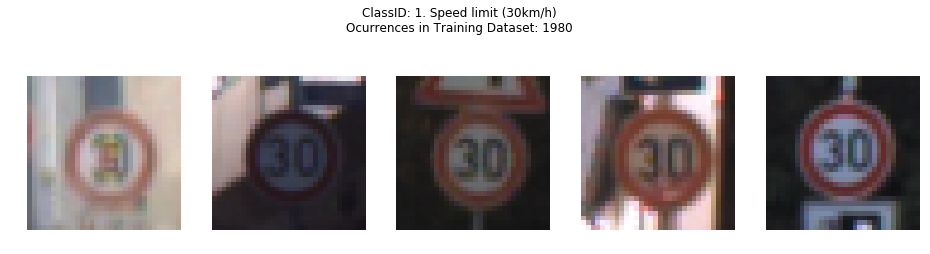

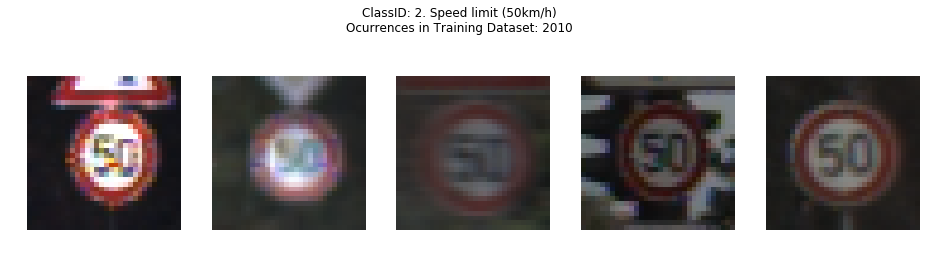

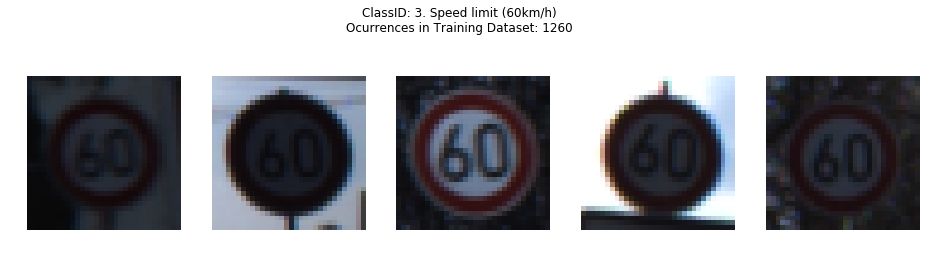

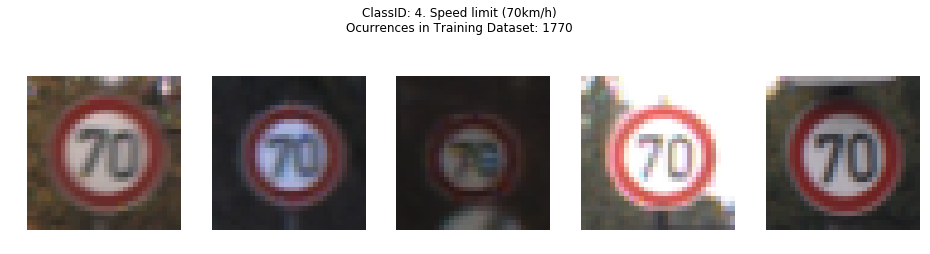

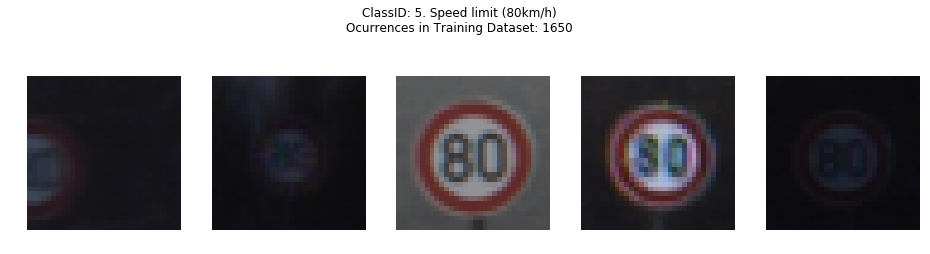

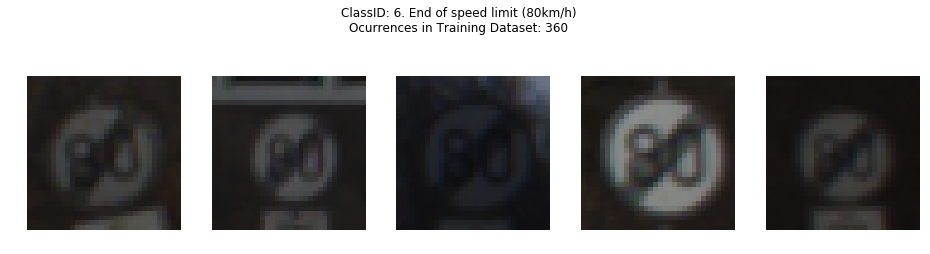

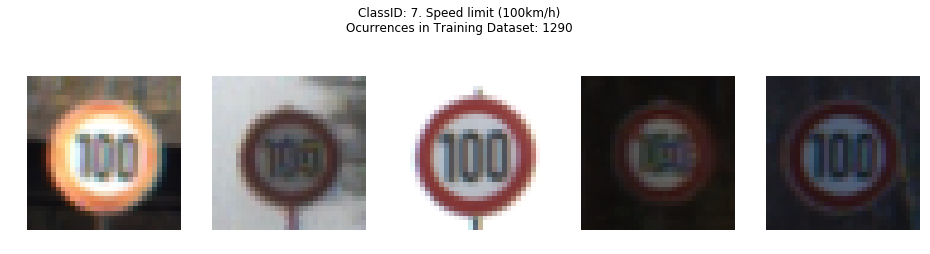

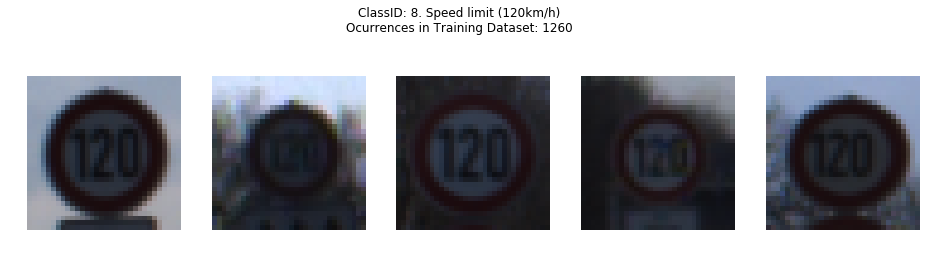

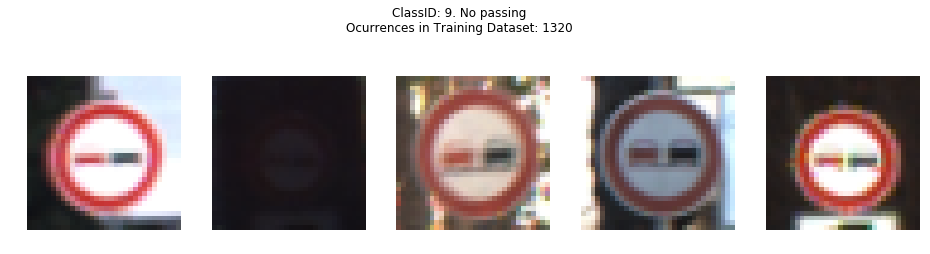

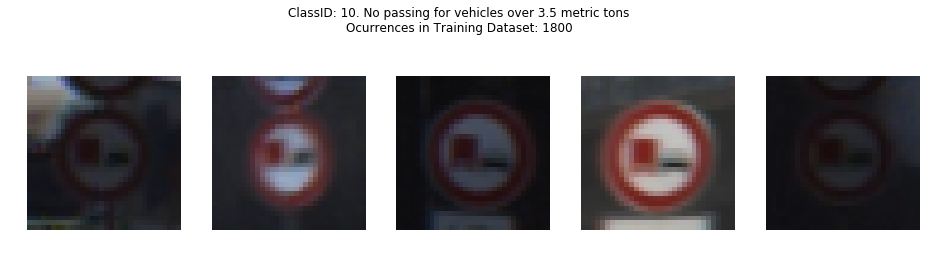

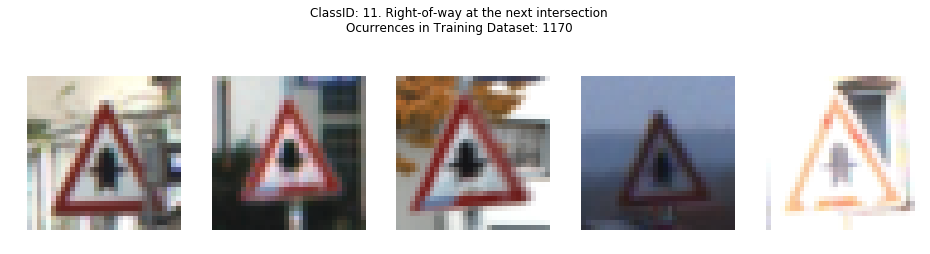

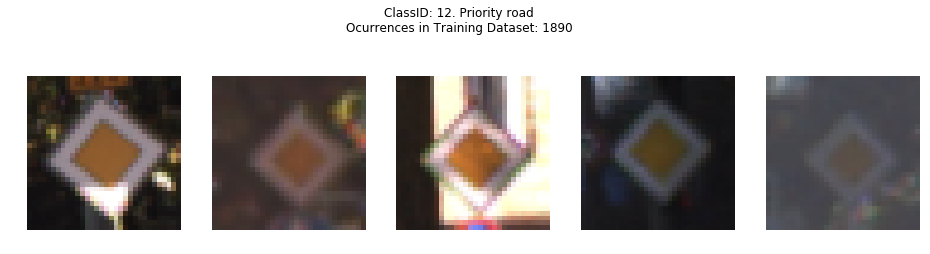

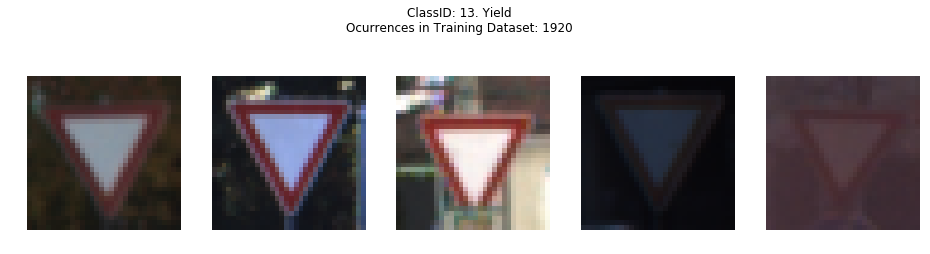

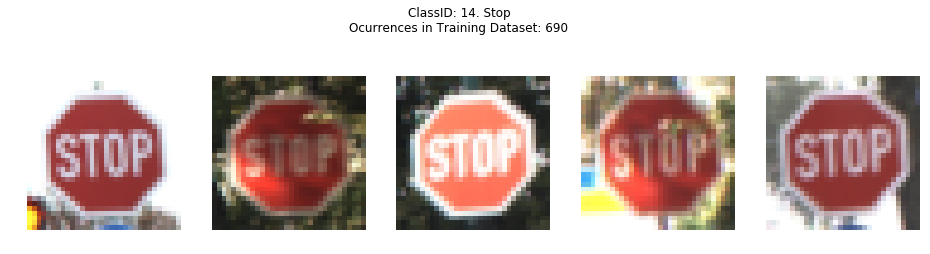

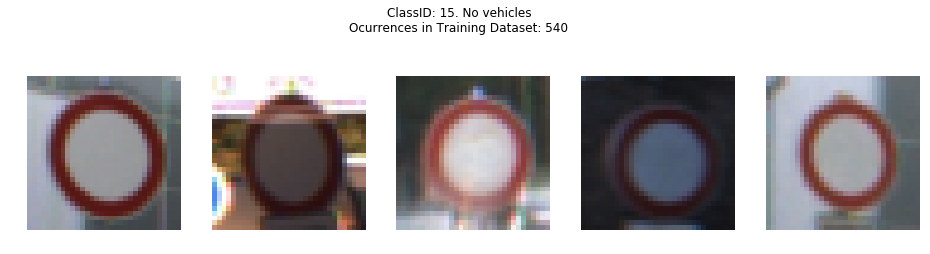

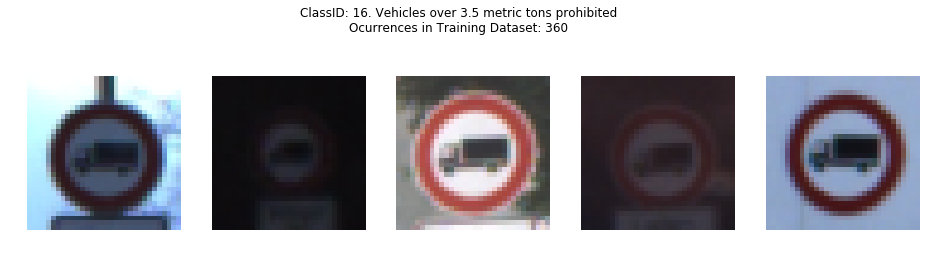

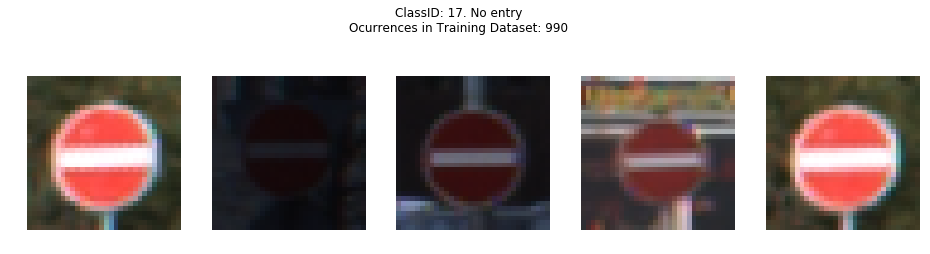

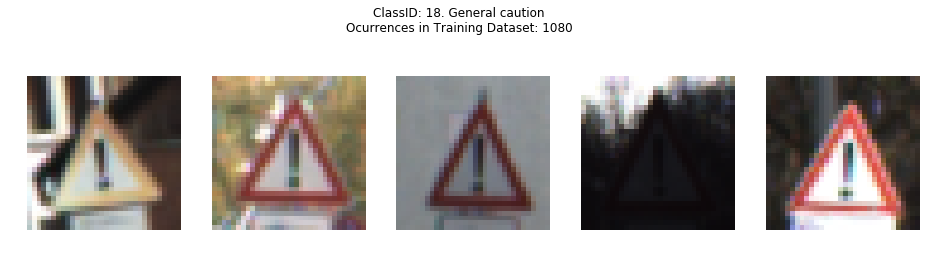

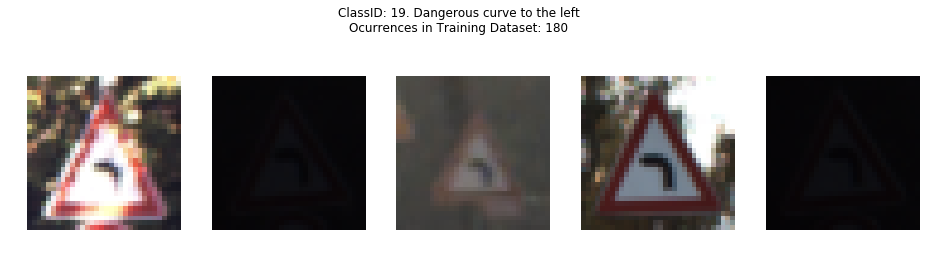

In [4]:
### Define a function to read the signnames.csv file. This file contains the class number vs the traffic sign name
### for our database. Then we store this information into variables (including the count of each sign).

def read_sign_names(file): 
    """
    Keyword arguments:
    file -- a two-column csv file with a header
    Returns variables for the class number and traffic sign name.
    """
    fid = open(file, 'r')
    lines = fid.readlines()
    t = 0
    number = []
    name = []
    for line in lines:
        aux = line.split(',')
        if t >= 1:
            number.append(aux[0])
            name.append(aux[1])
        t += 1
    fid.close()
    return number, name

sign_number, sign_name = read_sign_names(SIGNNAMES_FILE)

sign_counts = np.bincount(y_train)

### Data visualization: Here we plot 5 randomly selected images for each traffic sign (43 classes).
### In each figure the sign name, and the number of counts in the training dataset are shown in the title.
### The first 20 classes are shown in the following 20 figures:

index = []
for i in range(20):
    fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1]/2))
    fig.suptitle('ClassID: ' + str(sign_number[i]) + '. ' + str(sign_name[i]) + 'Ocurrences in Training Dataset: ' + str(sign_counts[i]), fontsize=12)
    for j in range(DATASET_DISPLAY):
        plt.subplot(1, DATASET_DISPLAY, j+1)
        plt.axis('off')
        index.append(random.randint(0, np.nonzero(y_train == i)[0].shape[0]-1))
        plt.imshow(X_train_original[np.nonzero(y_train == i)[0][index[-1]], :, :])
    fig.savefig('my_images/visualization'+str(i)+'_ch'+str(CHANNELS)+'.jpg', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None,
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)

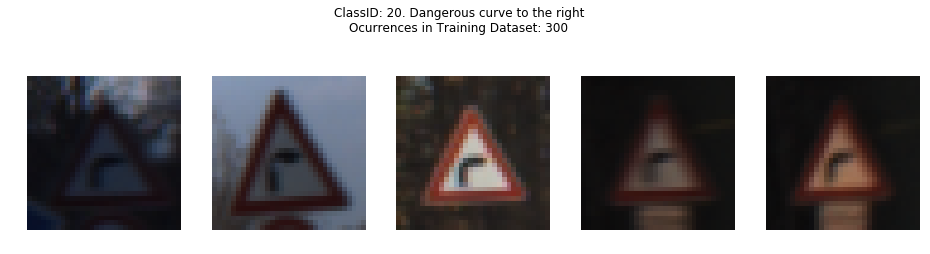

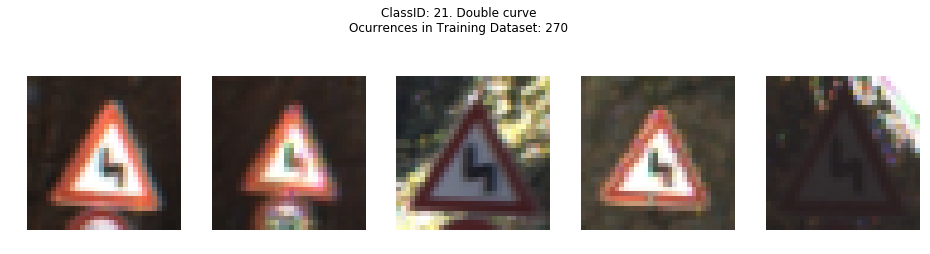

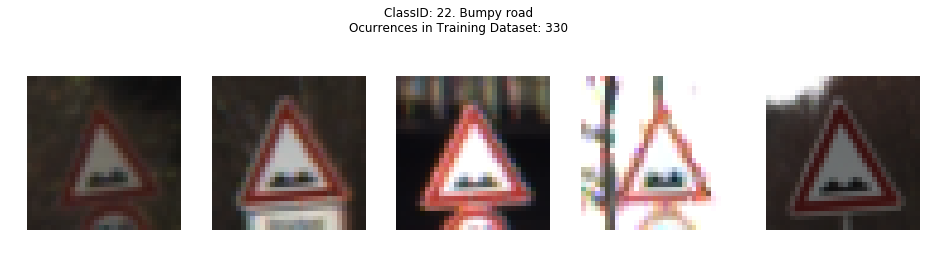

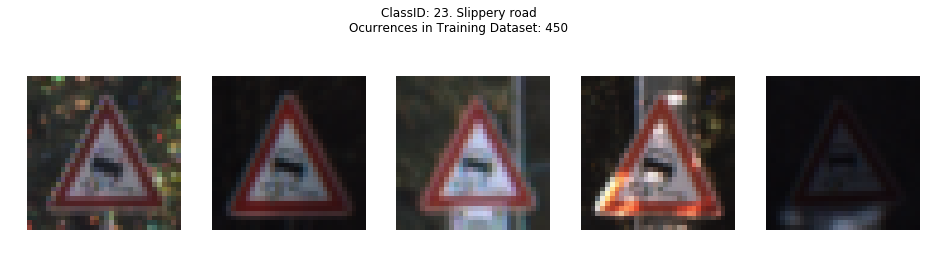

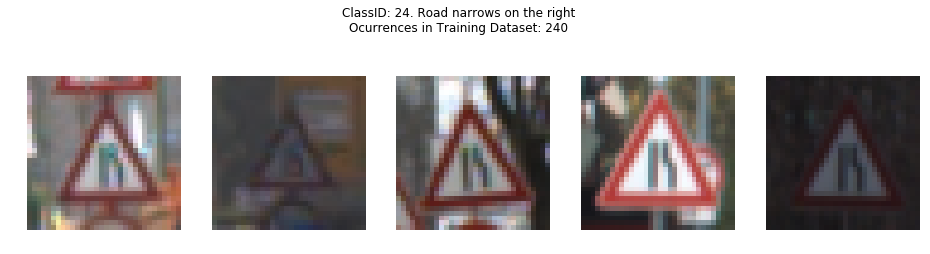

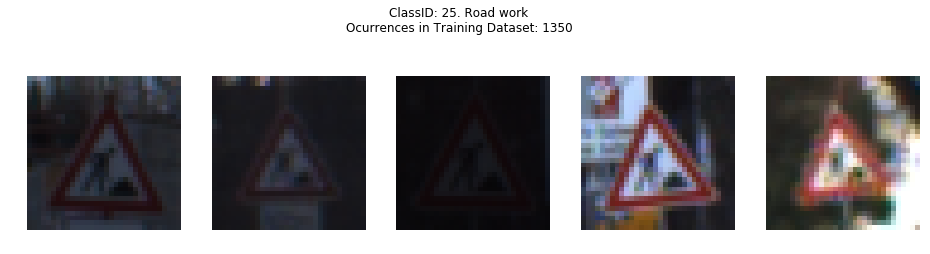

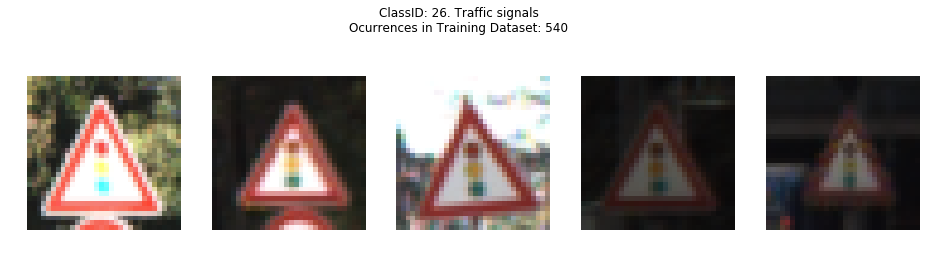

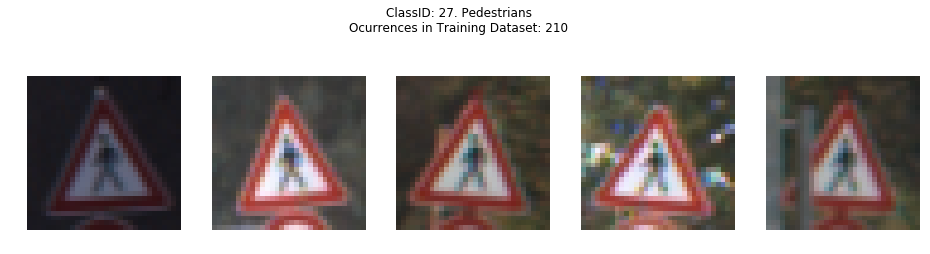

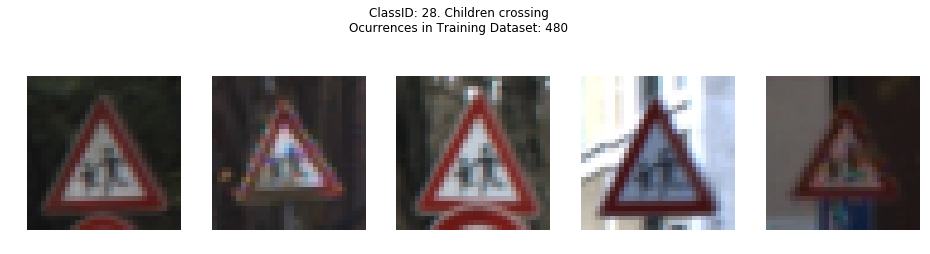

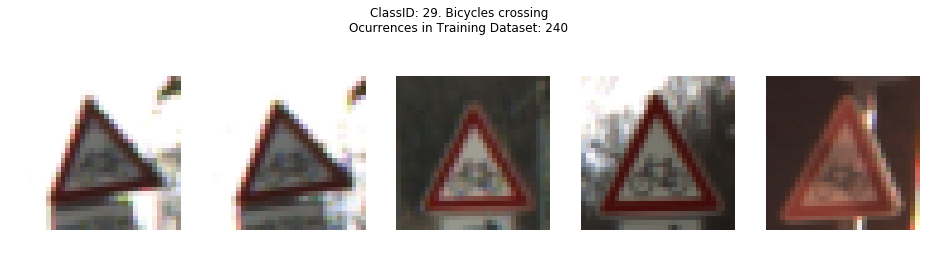

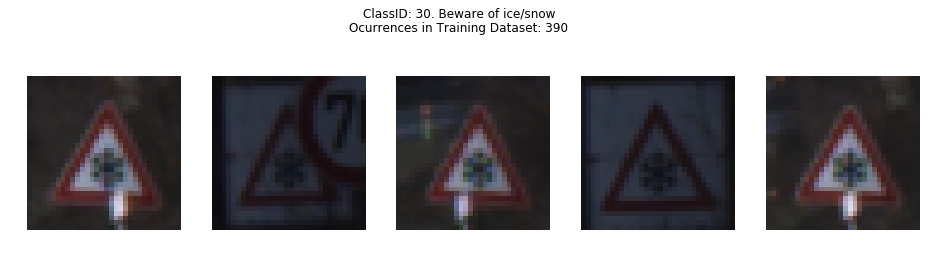

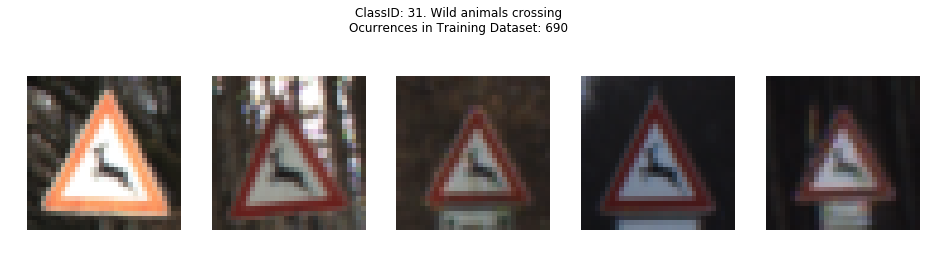

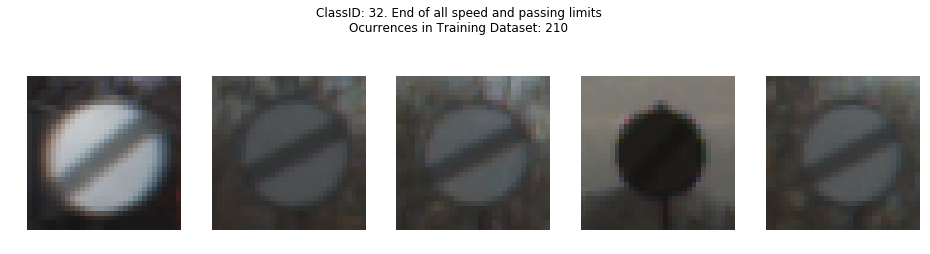

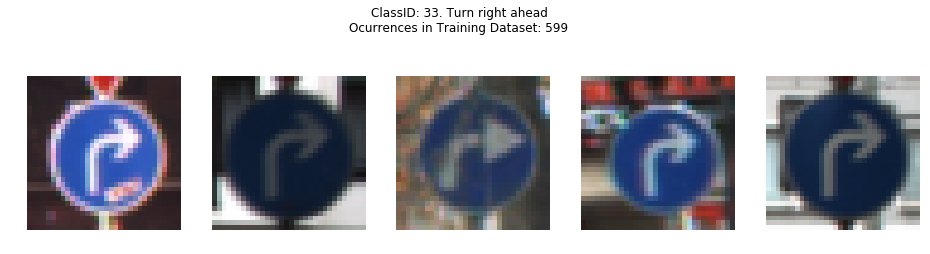

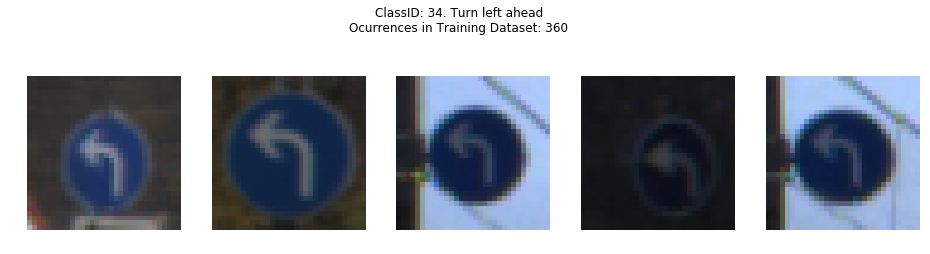

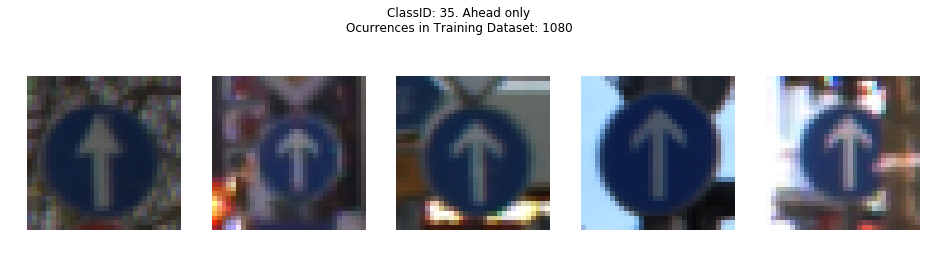

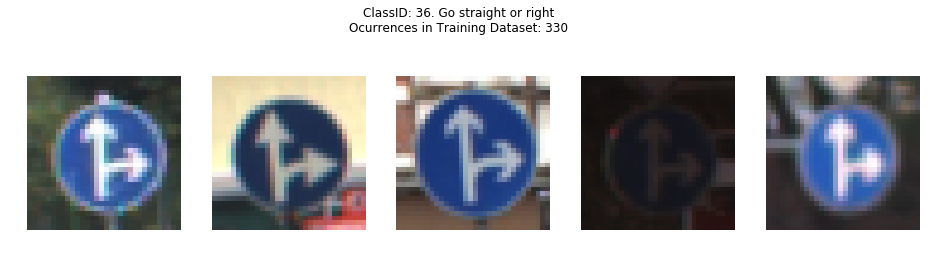

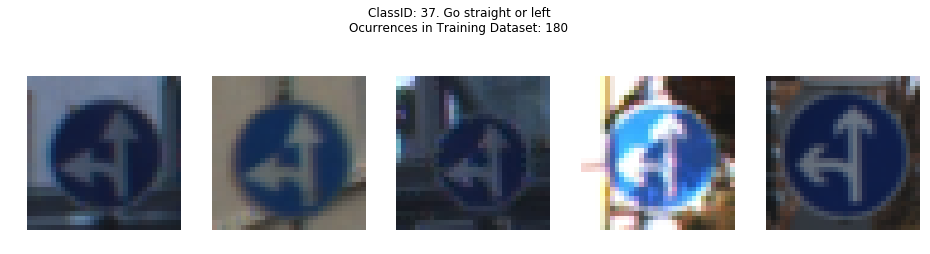

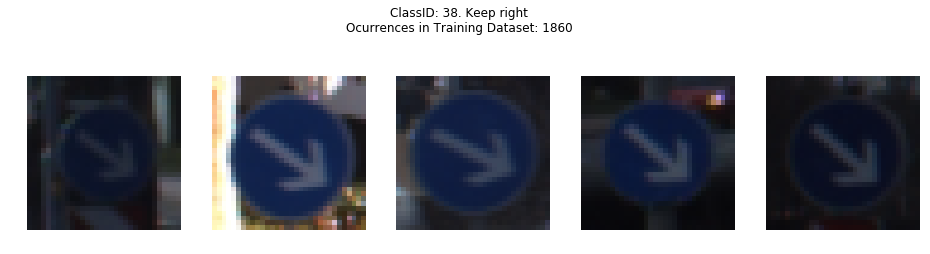

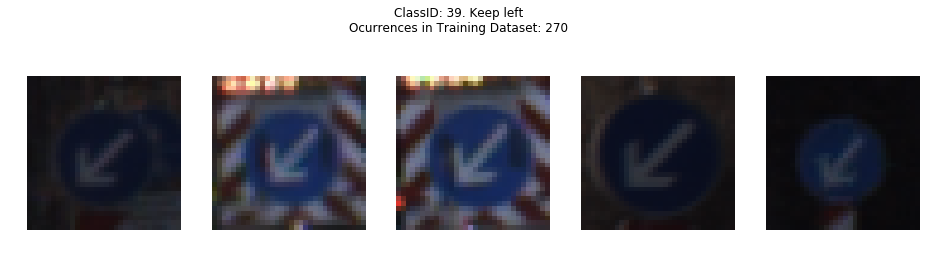

In [5]:
### Data visualization (continued).
### The next 20 classes are shown in the following 20 figures:

for i in range(20,40):
    fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1]/2))
    fig.suptitle('ClassID: ' + str(sign_number[i]) + '. ' + str(sign_name[i]) + 'Ocurrences in Training Dataset: ' + str(sign_counts[i]), fontsize=12)
    for j in range(DATASET_DISPLAY):
        plt.subplot(1, DATASET_DISPLAY, j+1)
        plt.axis('off')
        index.append(random.randint(0, np.nonzero(y_train == i)[0].shape[0]-1))
        plt.imshow(X_train_original[np.nonzero(y_train == i)[0][index[-1]], :, :])
    fig.savefig('my_images/visualization'+str(i)+'_ch'+str(CHANNELS)+'.jpg', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None,
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)

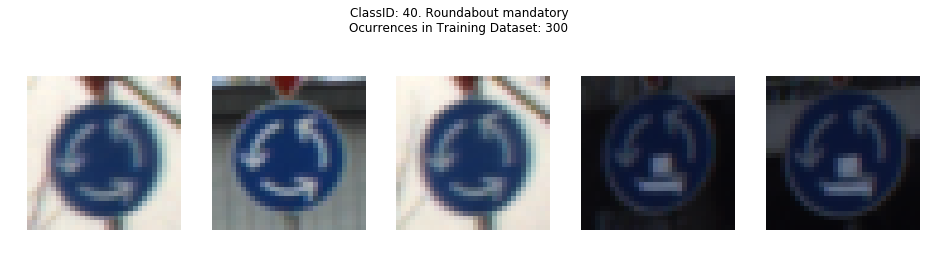

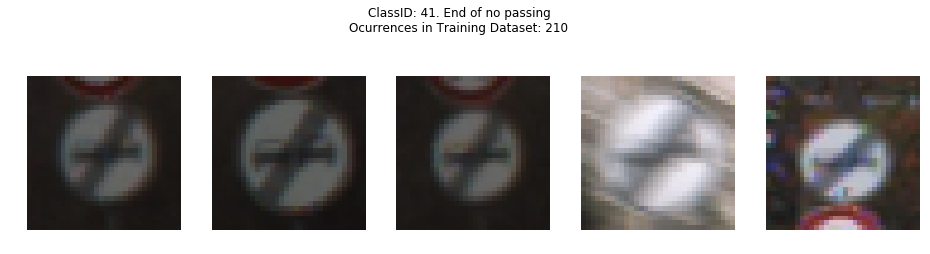

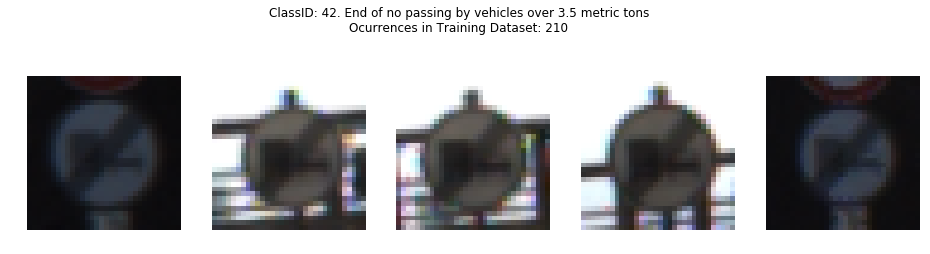

In [6]:
### Data visualization (continued).
### The next 3 classes are shown in the following 3 figures.
### This finishes the visualization of the raw images of our dataset.

for i in range(40,n_classes):
    fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1]/2))
    fig.suptitle('ClassID: ' + str(sign_number[i]) + '. ' + str(sign_name[i]) + 'Ocurrences in Training Dataset: ' + str(sign_counts[i]), fontsize=12)
    for j in range(DATASET_DISPLAY):
        plt.subplot(1, DATASET_DISPLAY, j+1)
        plt.axis('off')
        index.append(random.randint(0, np.nonzero(y_train == i)[0].shape[0]-1))
        plt.imshow(X_train_original[np.nonzero(y_train == i)[0][index[-1]], :, :])
    fig.savefig('my_images/visualization'+str(i)+'_ch'+str(CHANNELS)+'.jpg', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None,
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)

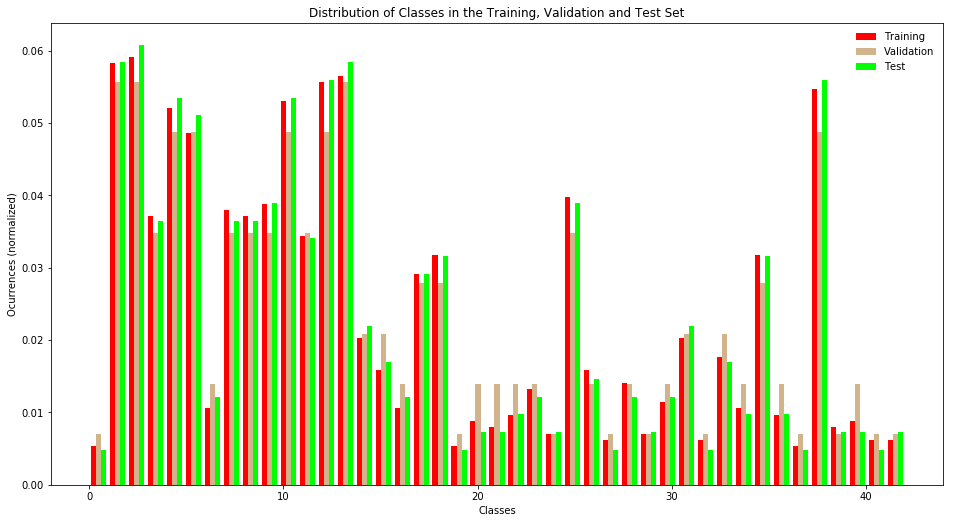

In [7]:
### Now we plot the count of each sign for our database (normalized)
### The distribution for the Training images is in red, for Validation images is in tan, and for Test images is in lime.

fig, ax0 = plt.subplots(nrows=1, ncols=1, figsize=SCREENSIZE)
colors = ['red', 'tan', 'lime']
ax0.hist([y_train, y_valid, y_test], n_classes, normed=1, histtype='bar', color=colors, label=['Training', 'Validation', 'Test'])
ax0.legend(prop={'size': 10}, loc='upper right', frameon=False)
ax0.set_title('Distribution of Classes in the Training, Validation and Test Set')
ax0.set_xlabel('Classes')
ax0.set_ylabel('Ocurrences (normalized)')
fig.savefig('my_images/classes_distribution.png', dpi=300, facecolor='w', edgecolor='w', orientation='portrait', papertype=None, format=None,
        transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)

In [ ]:
### We can see from this histogram for the Training, Validation, and Test distributions that they are highly 
### unbalanced across classes. But in a similar way amongst them. 
### The distributions are normalized in this plot, but as we have seen they have very different total sizes 
### (Training = 34799 images, Validation = 4410 images, and Test = 12630 images)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [8]:
### Here I define the functions necessary to pre-process our dataset.

def preprocessing_grayscale(image_data):
    """
    Keyword arguments:
    image_data -- any image from our dataset.
    Returns a gray-scale equivalent of the input.
    """
    return cv2.cvtColor(image_data, cv2.COLOR_RGB2GRAY) # Or use BGR2GRAY if you read an image with cv2.imread()

### For the normalization procedure, 
### I *extend the dynamic range* from the raw images to a full extent from -0.5 to 0.5, with a zero mean
### (minimum raw will correspond to pre-processed -0.5, while maximum raw will correspond to pre-processed 0.5):

def preprocessing_normalization(image_data):
    """
    Keyword arguments:
    image_data -- any image from our dataset.
    Returns a normalized equivalent of the input (zero mean and full dynamic range).
    """
    xmin = np.min(image_data)
    xmax = np.max(image_data)
    a = -0.5
    b = 0.5
    return a + (image_data-xmin)*(b-a)/(xmax-xmin)


In [9]:
### Here we apply the pre-processing for each image in our Training, Validation, and Test databases.
### If we choose to train our CNN with grayscale images we apply both the grayscale and normalization functions
### defined above.
### If we train the CNN with color images we use the equalizeHist function from OpenCV, which  
### normalizes the brightness and increases the contrast of the image.

### I did choose to use gray-scale images for CNN training, as validation accuracy is improved this way.

if CHANNELS == 1:
    X_train = np.array(list(map(lambda x: preprocessing_grayscale(x), X_train_original)))
    X_train = X_train[..., None]
    X_train = np.array(list(map(lambda x: preprocessing_normalization(x), X_train)))

    X_valid = np.array(list(map(lambda x: preprocessing_grayscale(x), X_valid_original)))
    X_valid = X_valid[..., None]
    X_valid = np.array(list(map(lambda x: preprocessing_normalization(x), X_valid)))

    X_test = np.array(list(map(lambda x: preprocessing_grayscale(x), X_test_original)))
    X_test = X_test[..., None]
    X_test = np.array(list(map(lambda x: preprocessing_normalization(x), X_test)))
else:
    assert CHANNELS == 3
    for channel in range(CHANNELS):
        X_train[:, :, :, channel] = np.array(list(map(lambda x: cv2.equalizeHist(x), X_train_original[:, :, :, channel])))
        X_valid[:, :, :, channel] = np.array(list(map(lambda x: cv2.equalizeHist(x), X_valid_original[:, :, :, channel])))
        X_test[:, :, :, channel] = np.array(list(map(lambda x: cv2.equalizeHist(x), X_test_original[:, :, :, channel])))


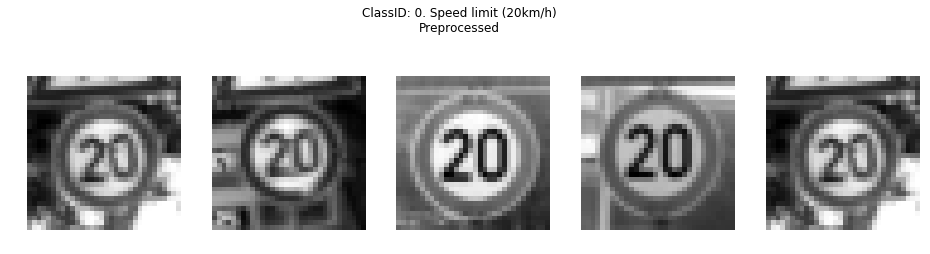

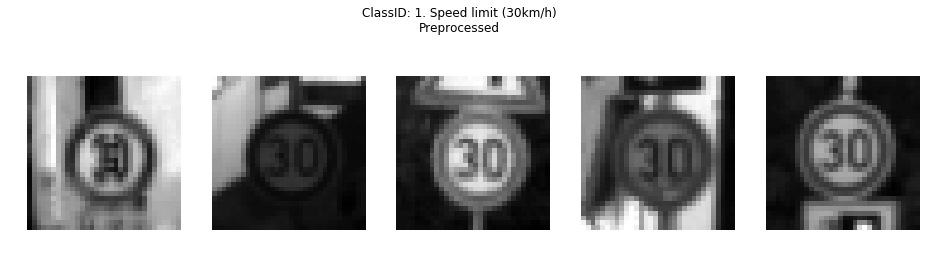

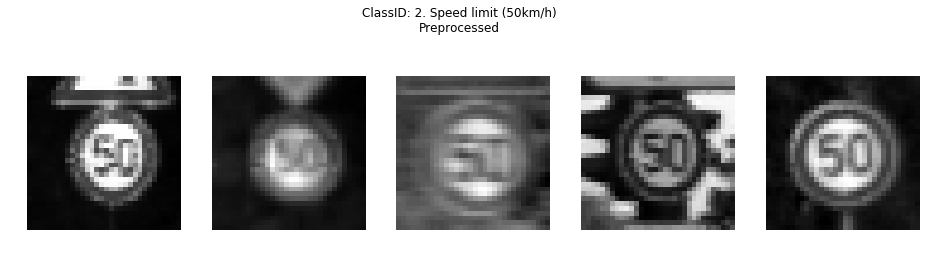

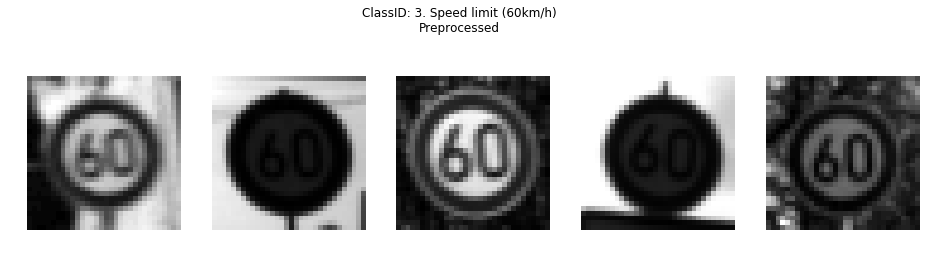

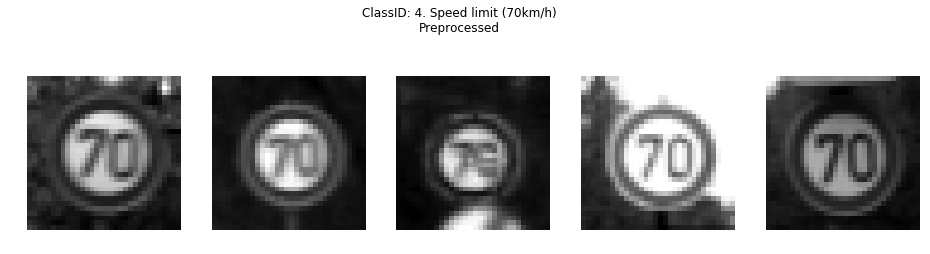

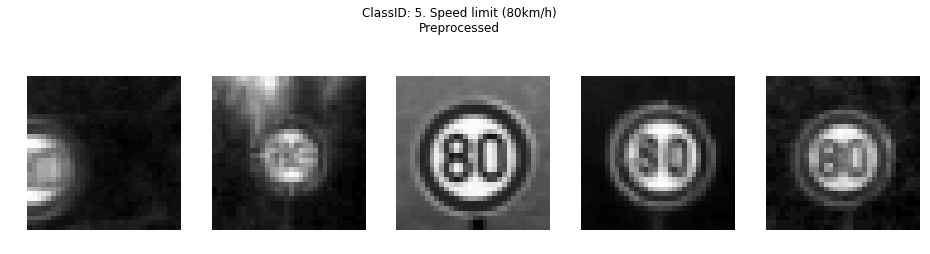

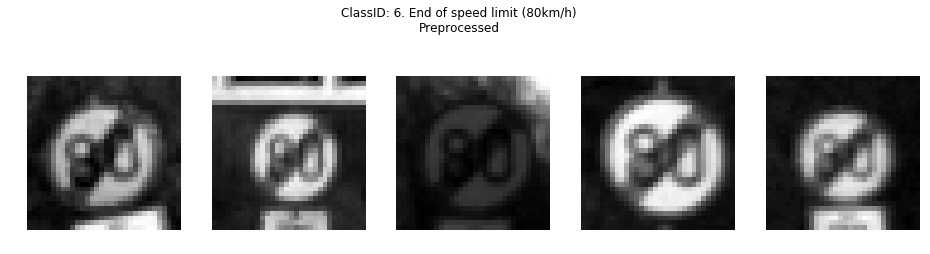

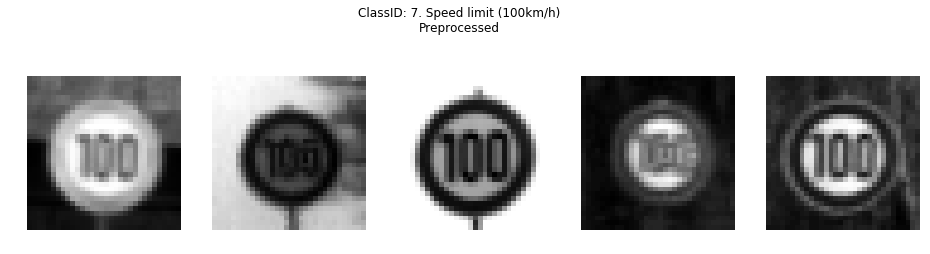

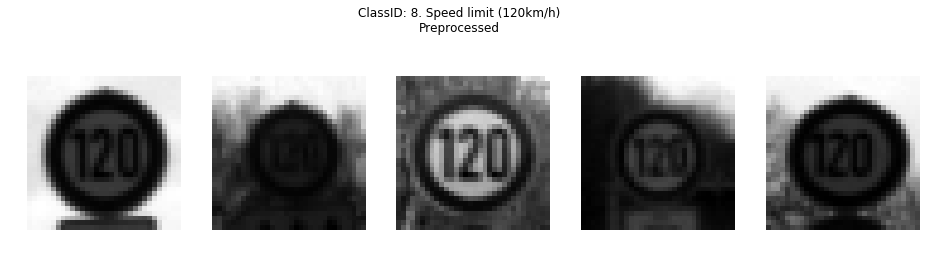

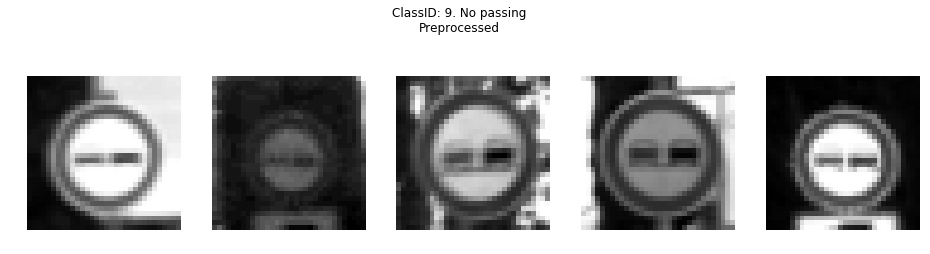

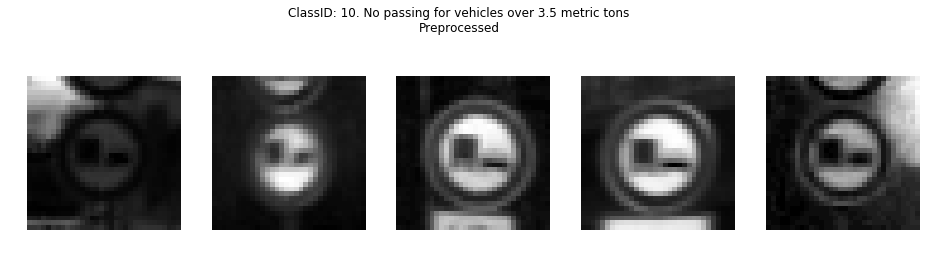

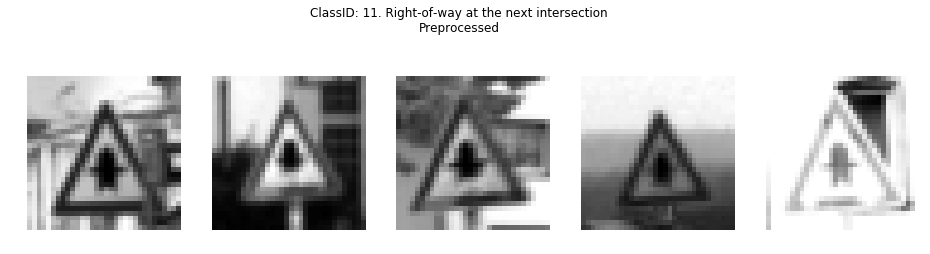

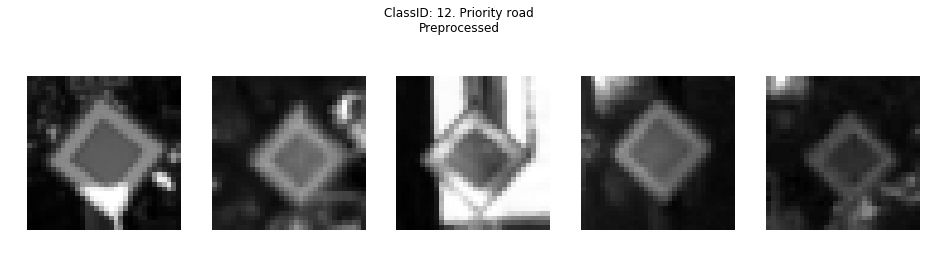

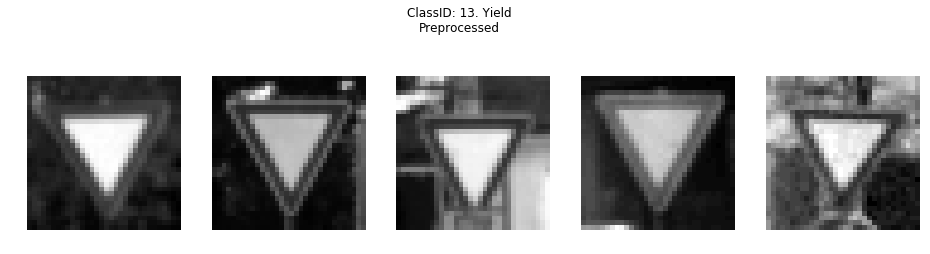

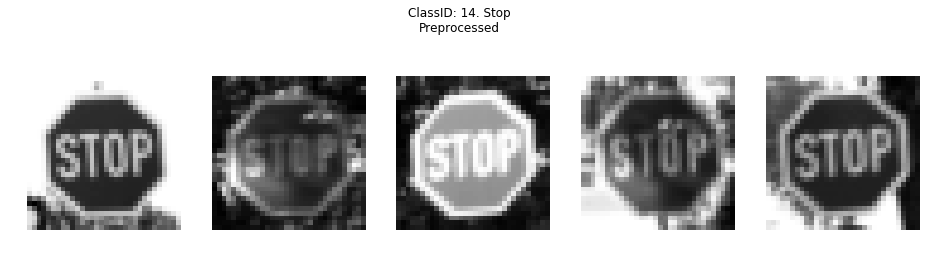

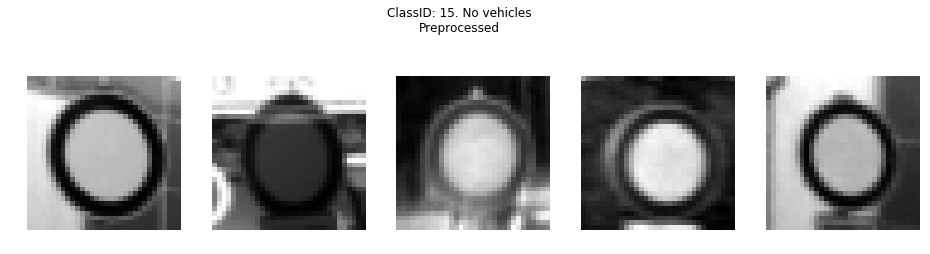

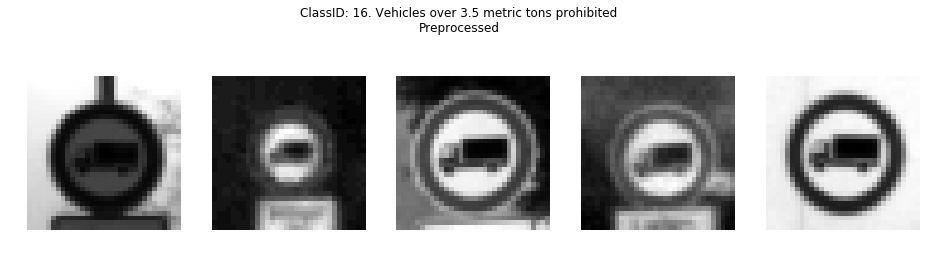

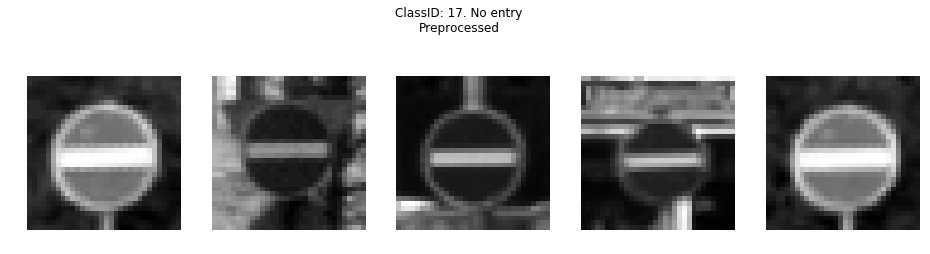

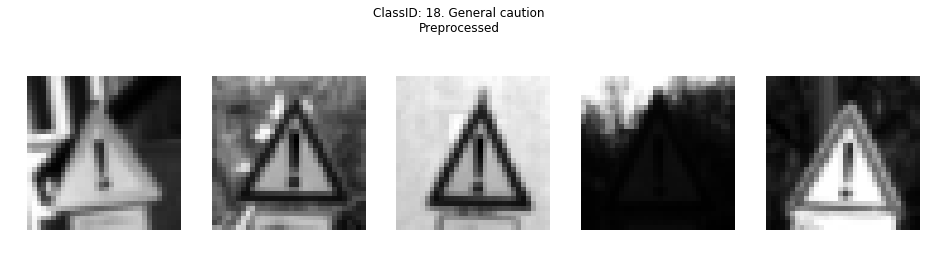

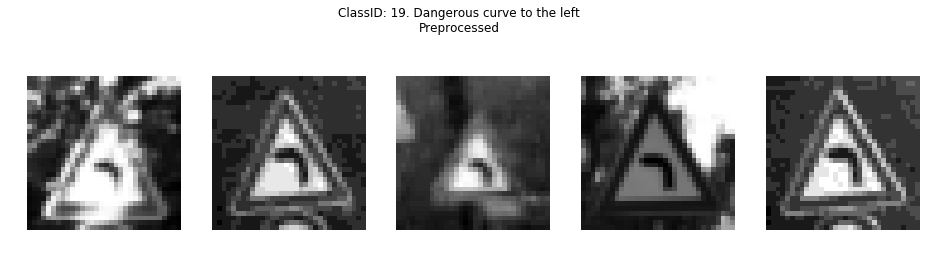

In [10]:
### Data visualization of the Pre-processed DataSet: 
### The same 5 randomly selected images for each sign shown in the DataSet Visualization section are seen here.
### Only the first 20 classes are included in the following 20 figures (grayscale and normalined pre-processed):

t = 0
for i in range(20):
    fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1]/2))
    fig.suptitle('ClassID: ' + str(sign_number[i]) + '. ' + str(sign_name[i]) + 'Preprocessed', fontsize=12)
    for j in range(DATASET_DISPLAY):
        plt.subplot(1, DATASET_DISPLAY, j+1)
        plt.axis('off')
        if CHANNELS == 1:
            plt.imshow(np.squeeze(X_train[np.nonzero(y_train == i)[0][index[t]], :, :]), cmap='gray')
            t += 1
        if CHANNELS == 3:
            plt.imshow(X_train[np.nonzero(y_train == i)[0][index[t]], :, :])
            t += 1
    fig.savefig('my_images/preproc'+str(i)+'_ch'+str(CHANNELS)+'.jpg', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None,
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)


### Model Architecture

In [11]:
### These are the functions that I'll use in the model architecture of my CNN.
### They define a i) convolutional 2D layer, ii) max pool layer, and finally iii) a fully connected layer.

def conv2d(input, filter_shape, filter_mean, filter_stddev, strides, padding_scheme, activation):
    """
    This function takes as parameters the input image, filter characteristics (shape, mean, standard deviation for init), 
    and the stride and padding schemes. Also it has the option for activation (via a ReLU function).
    It returns the result of a 2d convolutional layer
    ### Output shape if using 'VALID' padding:
    ### out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    ### out_width  = ceil(float(in_width  - filter_width  + 1) / float(strides[2]))
    ### out_depth  = filter_depth (filter_shape[3])
    """
    # Filter weight shape: (height, width, input_depth, output_depth) / Filter bias shape: (output_depth)
    # Stride shape: (batch_size, height, width, depth)
    f_w = tf.Variable(tf.truncated_normal(shape=filter_shape, mean=filter_mean, stddev=filter_stddev))
    f_b = tf.Variable(tf.zeros([filter_shape[3]]))
    conv = tf.nn.conv2d(input, f_w, strides, padding_scheme) + f_b
    if activation == 'YES':
        conv = tf.nn.relu(conv)
    return conv

def maxpool(input, filter_shape, strides, padding_scheme):
    """
    This function takes as parameters the input image, the ksize, strides and padding scheme.
    It returns the result of a max pool convolutional layer
    ### Output shape if using 'VALID' padding:
    ### out_height = ceil(float(in_height - filter_height + 1) / float(strides[1]))
    ### out_width  = ceil(float(in_width  - filter_width  + 1) / float(strides[2]))
    ### out_depth  = input depth
    """
    return tf.nn.max_pool(input, ksize=filter_shape, strides=strides, padding=padding_scheme)


def fully_connected(input, filter_shape, filter_mean, filter_stddev, activation):
    """
    This function takes as parameters the input image, filter characteristics (shape, mean, standard deviation for init). 
    Also it has the option for activation (via a ReLU function).
    It returns the result of a traditional fully connected layer.
    ### Output shape:
    ### out_depth  = filter width (filter_shape[1])    f_w = tf.Variable(tf.truncated_normal(shape=filter_shape, mean=filter_mean, stddev=filter_stddev))
    """
    f_b = tf.Variable(tf.zeros(filter_shape[1]))
    fc = tf.matmul(input, f_w) + f_b
    if activation == 'YES':
        fc = tf.nn.relu(fc)
    return fc



In [12]:
### The architecture of my model is defined here. It's composed by 4 convolutional layers (all but one with maxpool)
### followed by three fully connected layers. This architecture follows closely the AlexNet implementation
### (http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks).

### Some changes w.r.t. AlexNet are due to the small dimension of our dataset images, i) layer dimensions are
### smaller, and we have one less convolutional layer. We applied dropout in all but one fully-connected layer for
### regularization purposes.

def model_architecture(x, keep_prob):
    """
    This function takes as parameters an input image and keep probability (for dropout).
    It returns logits to be used in the inference of classes stage.
    
    The architecture is as follows:
    -Layer 1:    2D Convolution (3x3 filter with depth=12, stride=1, valid padding)     32x32xchannels to 30x30x12
                 ReLU activation
                 Max pooling    (2x2 filter, stride=2, valid padding)                   30x30x12 to 15x15x12
    -Layer 2:    2D Convolution (3x3 filter with depth=32, stride=1, valid padding)     15x15x12 to 13x13x32
                 ReLU activation
                 Max pooling    (2x2 filter, stride=1, valid padding)                   13x13x32 to 12x12x32
    -Layer 3:    2D Convolution (3x3 filter with depth=64, stride=1, valid padding)     12x12x32 to 10x10x64
                 ReLU activation
    -Layer 4:    2D Convolution (3x3 filter with depth=128, stride=1, valid padding)    10x10x64 to 8x8x128
                 ReLU activation
                 Max pooling    (2x2 filter, stride=3, valid padding                    8x8x128  to 4x4x128
    -Layer 5:    Fully-connected(512 neurons)                                           4x4x128  to 512
                 ReLU activation
                 Dropout        (keep_prob = 0.7)
    -Layer 6:    Fully-connected(128 neurons)                                           512      to 128
                 ReLU activation
                 Dropout        (keep_prob = 0.7)
    -Layer 7:    Fully-connected(43 neurons)                                            128      to 43
    """
    layer1 = conv2d(x, [3, 3, CHANNELS, 12], MU, SIGMA, [1, 1, 1, 1], 'VALID', 'YES') ### 32x32xch to 30x30x12
    layer1 = maxpool(layer1, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')                     ### 30x30x12 to 15x15x12

    layer2 = conv2d(layer1, [3, 3, 12, 32], MU, SIGMA, [1, 1, 1, 1], 'VALID', 'YES')  ### 15x15x12 to 13x13x32
    layer2 = maxpool(layer2, [1, 2, 2, 1], [1, 1, 1, 1], 'VALID')                     ### 13x13x32 to 12x12x32

    layer3 = conv2d(layer2, [3, 3, 32, 64], MU, SIGMA, [1, 1, 1, 1], 'VALID', 'YES')  ### 12x12x32 to 10x10x64
    layer4 = conv2d(layer3, [3, 3, 64, 128], MU, SIGMA, [1, 1, 1, 1], 'VALID', 'YES') ### 10x10x64 to 8x8x128
    layer4 = maxpool(layer4, [1, 2, 2, 1], [1, 2, 2, 1], 'VALID')                     ### 8x8x128  to 4x4x128

    layer5 = fully_connected(flatten(layer4), [2048, 512], MU, SIGMA, 'YES')          ### 4x4x128  to 2048 to 512
    layer5 = tf.nn.dropout(layer5, keep_prob)
    layer6 = fully_connected(layer5, [512, 128], MU, SIGMA, 'YES')                    ### 512      to 128
    layer6 = tf.nn.dropout(layer6, keep_prob)
    layer7 = fully_connected(layer6, [128, n_classes], MU, SIGMA, 'NO')               ### 128      to n_classes
    return layer7

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [13]:
### Here we start the Graph for our TensorFlow session. First we initialize the CNN structure and then run
### the session, in this case for the training and validation of our model. 

### To prevent overfitting we train our model for 10 epochs only, when we achieve the max training accuracy.
### For these 10 epochs we report training and validation accuracies (numerical output in screen and plots) below.

### Once we achieve the required validation accuracy of 0.93 (and more, actually we obtain ~0.98) we save the
### parameters of our model in the saved/ folder

with TimeExecution():
    graph = tf.Graph()
    with graph.as_default():
        X_train, y_train = shuffle(X_train, y_train)
        x = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
        y = tf.placeholder(tf.int32, (None))
        one_hot_y = tf.one_hot(y, n_classes)

        keep_prob = tf.placeholder(tf.float32)
        logits = model_architecture(x, keep_prob)
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
        loss_operation = tf.reduce_mean(cross_entropy)
        optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
        training_operation = optimizer.minimize(loss_operation)

        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
        accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        saver = tf.train.Saver()

    with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        num_examples = len(X_train)

        def evaluate_accuracy(X_data, y_data):
            num_examples = len(X_data)
            total_accuracy = 0
            sess = tf.get_default_session()
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
                accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
                total_accuracy += (accuracy * len(batch_x))
            return total_accuracy / num_examples

        print("Training...")
        print()

        accuracy_training = np.empty((0, EPOCHS))
        accuracy_validation = np.empty((0, EPOCHS))
        for i in range(EPOCHS):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: KEEP_PROB})

            accuracy_training = np.append(accuracy_training, [evaluate_accuracy(X_train, y_train)])
            accuracy_validation = np.append(accuracy_validation, [evaluate_accuracy(X_valid, y_valid)])

            print("EPOCH {} ...".format(i + 1))
            print("Training Accuracy = {:.3f}".format(accuracy_training[i]), "Validation Accuracy = {:.3f}".format(accuracy_validation[i]))
            print()

        saver.save(sess, SAVED_MODEL)
        print("Model saved")


Training...

EPOCH 1 ...
Training Accuracy = 0.907 Validation Accuracy = 0.857

EPOCH 2 ...
Training Accuracy = 0.979 Validation Accuracy = 0.941

EPOCH 3 ...
Training Accuracy = 0.992 Validation Accuracy = 0.954

EPOCH 4 ...
Training Accuracy = 0.995 Validation Accuracy = 0.959

EPOCH 5 ...
Training Accuracy = 0.997 Validation Accuracy = 0.968

EPOCH 6 ...
Training Accuracy = 0.998 Validation Accuracy = 0.968

EPOCH 7 ...
Training Accuracy = 0.998 Validation Accuracy = 0.970

EPOCH 8 ...
Training Accuracy = 0.998 Validation Accuracy = 0.977

EPOCH 9 ...
Training Accuracy = 0.999 Validation Accuracy = 0.969

EPOCH 10 ...
Training Accuracy = 1.000 Validation Accuracy = 0.982

Model saved
Runtime: 0:26:29.403989


TensorFlow Model Restored

Test Accuracy = 0.954



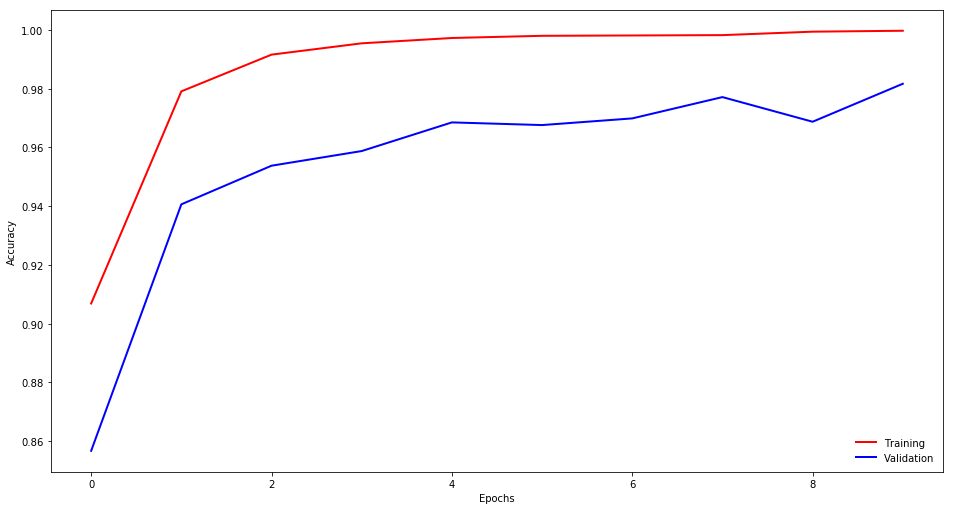

In [19]:
### Now it's time to Test the Model.

### We start the Graph for our TensorFlow session again, initialize the CNN structure and then recover the stored
### model parameters from the saved/ folder.

### We obtain an accuracy of 0.954 for the Test dataset. Aditionally we plot the training and validation accuracies
### as a function of time.


graph = tf.Graph()
with graph.as_default():
    x = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, n_classes)

    keep_prob = tf.placeholder(tf.float32)
    logits = model_architecture(x, keep_prob)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=RATE)
    training_operation = optimizer.minimize(loss_operation)

    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.train.Saver().restore(sess, SAVED_MODEL)
        print("TensorFlow Model Restored")
        print()

        def evaluate_accuracy(X_data, y_data):
            num_examples = len(X_data)
            total_accuracy = 0
            sess = tf.get_default_session()
            for offset in range(0, num_examples, BATCH_SIZE):
                batch_x, batch_y = X_data[offset:offset + BATCH_SIZE], y_data[offset:offset + BATCH_SIZE]
                accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
                total_accuracy += (accuracy * len(batch_x))
            return total_accuracy / num_examples

        accuracy_test = evaluate_accuracy(X_test, y_test)
        print("Test Accuracy = {:.3f}".format(accuracy_test))
        print()

        fig, ax1 = plt.subplots(ncols=1, nrows=1, figsize=SCREENSIZE)
        line1, = ax1.plot(range(EPOCHS), accuracy_training, 'r-', linewidth=2, label='Training')
        line2, = ax1.plot(range(EPOCHS), accuracy_validation, 'b-', linewidth=2, label='Validation')
        ax1.legend(loc='lower right', frameon=False)
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Accuracy')


In [ ]:
### In the plot above we show training and validation accuracies over the course of 10 epochs.
### We stop training of our CNN after we reach a plateau of maximum training accuracy, as the model can't keep 
### learning after this point and the problem of overfitting arises.

### As mentioned in the previous cell, we obtain an accuracy of 0.954 for the Test dataset. 


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [20]:
### We obtain 12 new images from the web and udacity forums. 
### These are stored at NEW_IMS_DIR = 'german_web_images/set_all'
### We load these new images with the method defined below:

def load_images_from_folder(folder):
    """
    This functions loads into an array all the images found in a given directory (the directory name is the input).
    """
    new_images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            new_images.append(img)
    return new_images


In [21]:
### Now the new images are resized, such as their shape becomes (32x32x3), the same as our original dataset.

new_images = np.array(load_images_from_folder(NEW_IMS_DIR))

X_new_original = np.empty((len(os.listdir(NEW_IMS_DIR)), 32, 32, 3), dtype=np.uint8)
for i in range(X_new_original.shape[0]):
    X_new_original[i, :, :, :] = cv2.resize(new_images[i], (32, 32), interpolation=cv2.INTER_AREA)
    X_new_original[i, :, :, :] = cv2.cvtColor(X_new_original[i, :, :, :], cv2.COLOR_BGR2RGB)


In [22]:
### The same pre-processing steps taken for the original dataset are followed here.

### If we choose to test on grayscale images we apply both the grayscale and normalization functions
### defined above.
### If we choose to test color images we use the equalizeHist function from OpenCV, which  
### normalizes the brightness and increases the contrast of the image.

### Again, we choose to use gray-scale images, as in the above training, validation and testing of our CNN.

X_new = np.empty((len(os.listdir(NEW_IMS_DIR)), 32, 32, CHANNELS), dtype=np.uint8)
if CHANNELS == 1:
    X_new = np.array(list(map(lambda x: preprocessing_grayscale(x), X_new_original)))
    X_new = X_new[..., None]
    X_new = np.array(list(map(lambda x: preprocessing_normalization(x), X_new)))
else:
    assert CHANNELS == 3
    for channel in range(CHANNELS):
        X_new[:, :, :, channel] = np.array(list(map(lambda x: cv2.equalizeHist(x), X_new_original[:, :, :, channel])))


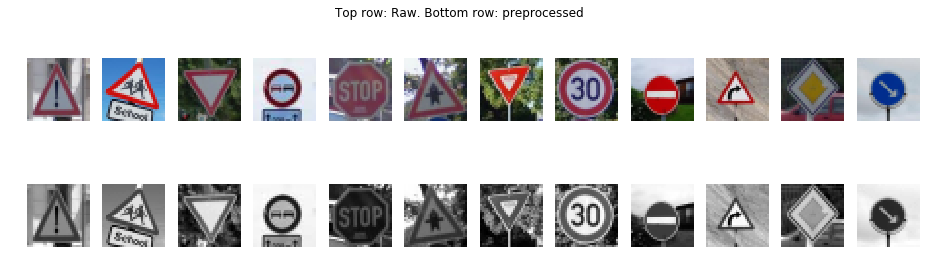

In [23]:
### Finally, we plot the raw original images (top row) and the result of the pre-processing (bottom row).

fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1]/2))
fig.suptitle('Top row: Raw. Bottom row: preprocessed', fontsize=12)
for j in range(X_new.shape[0]):
    plt.subplot(2, X_new.shape[0], j+1)
    plt.axis('off')
    plt.imshow(X_new_original[j, :, :])
    if CHANNELS == 1:
        plt.subplot(2, X_new.shape[0], X_new.shape[0] + j + 1)
        plt.axis('off')
        plt.imshow(np.squeeze(X_new[j, :, :]), cmap='gray')
    if CHANNELS == 3:
        plt.subplot(2, X_new.shape[0], X_new.shape[0] + j + 1)
        plt.axis('off')
        plt.imshow(X_new[j, :, :])
    fig.savefig('my_images/new_images.jpg', dpi=None, facecolor='w', edgecolor='w', orientation='portrait', papertype=None,
                format=None, transparent=False, bbox_inches='tight', pad_inches=0.1, frameon=None)

### Predict the Sign Type for Each Image

TensorFlow Model Restored



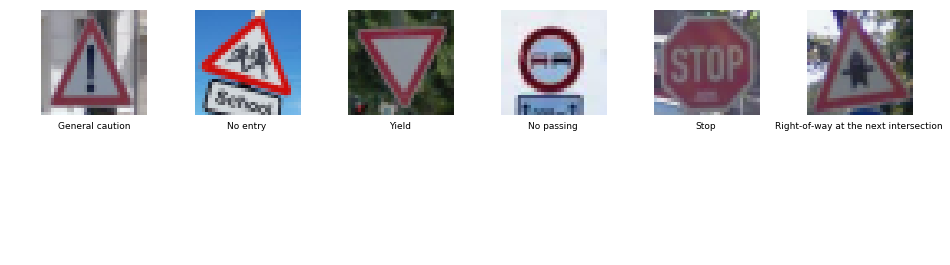

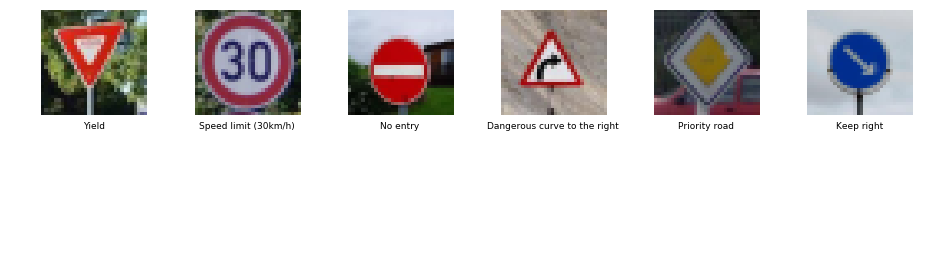

In [27]:
### We start the Graph for our TensorFlow session again, recreate the CNN structure and then recover the stored
### model parameters from the saved/ folder.

### The label predictions are computed using the np.argmax() function on the predicted logits. Via direct inspection
### of the signnames.csv file, we assign the corresponding label name for each of the new images.

### The described results are shown in the next plot.

graph = tf.Graph()
with graph.as_default():
    xnew = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
    keep_prob = tf.placeholder(tf.float32)
    logits = model_architecture(xnew, keep_prob)

    with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.train.Saver().restore(sess, SAVED_MODEL)
        print("TensorFlow Model Restored")
        print()

        predicted_logits = sess.run(logits, feed_dict={xnew: X_new, keep_prob: 1.0})
        predicted_labels = np.argmax(predicted_logits, axis=1)

        sign_number, sign_name = read_sign_names(SIGNNAMES_FILE)
        fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1] / 2))
        for j in range(6):
            plt.subplot(2, len(range(6)), j + 1)
            plt.axis('off')
            plt.imshow(X_new_original[j, :, :])
            plt.subplot(2, len(range(6)), len(range(6)) + j + 1)
            plt.axis('off')
            plt.text(0.5, 1.05, sign_name[predicted_labels[j]], horizontalalignment='center', verticalalignment = 'center', fontsize=9)
        fig.savefig('my_images/new_images_with_labels_part1.jpg', dpi=None, facecolor='w', edgecolor='w',
                    orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight',
                    pad_inches=0.1, frameon=None)
        fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1] / 2))
        t=0
        for j in range(6, X_new.shape[0]):
            plt.subplot(2, len(range(6)), t + 1)
            plt.axis('off')
            plt.imshow(X_new_original[j, :, :])
            plt.subplot(2, len(range(6)), len(range(6)) + t + 1)
            plt.axis('off')
            plt.text(0.5, 1.05, sign_name[predicted_labels[j]], horizontalalignment='center', verticalalignment = 'center', fontsize=9)
            t+=1
        fig.savefig('my_images/new_images_with_labels_part2.jpg', dpi=None, facecolor='w', edgecolor='w',
                    orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight',
                    pad_inches=0.1, frameon=None)


### Analyze Performance

In [29]:
### Although we are dealing with small number statistics here (we made predictions only for 12 new images), our CNN
### got 11 correct ones, and 1 wrong. This translates into a 91.7% accuracy of the model in the new dataset.

### However the one the model got wrong (School Sign) wasn't a part of the original dataset. Conservatively, we can
### then estimate the accuracy of our CNN model between 92-100%.

correct = 11
wrong   = 1
accuracy_newims = (correct)/(correct + wrong)
print("New Images Accuracy = {:.3f}".format(accuracy_newims))
print()


New Images Accuracy = 0.917



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

TensorFlow Model Restored



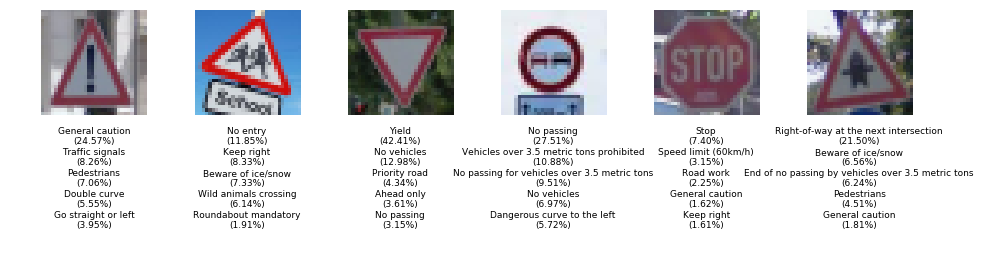

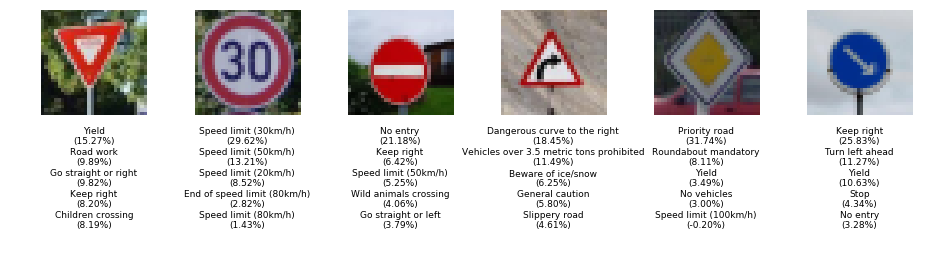

In [28]:
### We print out the top five softmax probabilities for the predictions on our new dataset.

### This is done in the plot below.

graph = tf.Graph()
with graph.as_default():
    xnew = tf.placeholder(tf.float32, (None, 32, 32, CHANNELS))
    keep_prob = tf.placeholder(tf.float32)
    logits = model_architecture(xnew, keep_prob)
    softmax_logits = tf.nn.softmax(logits)
    top_probs = tf.nn.top_k(logits, 5)

    with tf.Session(graph=graph, config=tf.ConfigProto(log_device_placement=True)) as sess:
        tf.train.Saver().restore(sess, SAVED_MODEL)
        print("TensorFlow Model Restored")
        print()

        top_probabilities = sess.run(top_probs, feed_dict={xnew: X_new, keep_prob: 1.0})

        sign_number, sign_name = read_sign_names(SIGNNAMES_FILE)
        fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1] / 2))
        for j in range(6):
            plt.subplot(2, len(range(6)), j + 1)
            plt.axis('off')
            plt.imshow(X_new_original[j, :, :])
            plt.subplot(2, len(range(6)), len(range(6)) + j + 1)
            plt.axis('off')
            plt.text(0.5, 1.0, sign_name[top_probabilities[1][j][0]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.95, "({:.2f}%)".format(top_probabilities[0][j][0]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.8, sign_name[top_probabilities[1][j][1]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.75, "({:.2f}%)".format(top_probabilities[0][j][1]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.6, sign_name[top_probabilities[1][j][2]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.55, "({:.2f}%)".format(top_probabilities[0][j][2]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.4, sign_name[top_probabilities[1][j][3]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.35, "({:.2f}%)".format(top_probabilities[0][j][3]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.2, sign_name[top_probabilities[1][j][4]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.15, "({:.2f}%)".format(top_probabilities[0][j][4]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
        fig.savefig('my_images/new_images_with_toplabels_part1.jpg', dpi=None, facecolor='w', edgecolor='w',
                        orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight',
                        pad_inches=0.1, frameon=None)
        fig = plt.figure(figsize=(SCREENSIZE[0], SCREENSIZE[1] / 2))
        t=0
        for j in range(6, X_new.shape[0]):
            plt.subplot(2, len(range(6)), t + 1)
            plt.axis('off')
            plt.imshow(X_new_original[j, :, :])
            plt.subplot(2, len(range(6)), len(range(6)) + t + 1)
            plt.axis('off')
            plt.text(0.5, 1.0, sign_name[top_probabilities[1][j][0]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.95, "({:.2f}%)".format(top_probabilities[0][j][0]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.8, sign_name[top_probabilities[1][j][1]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.75, "({:.2f}%)".format(top_probabilities[0][j][1]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.6, sign_name[top_probabilities[1][j][2]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.55, "({:.2f}%)".format(top_probabilities[0][j][2]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.4, sign_name[top_probabilities[1][j][3]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.35, "({:.2f}%)".format(top_probabilities[0][j][3]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.2, sign_name[top_probabilities[1][j][4]], horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            plt.text(0.5, 0.15, "({:.2f}%)".format(top_probabilities[0][j][4]), horizontalalignment='center',
                     verticalalignment='center', fontsize=9)
            t+=1
        fig.savefig('my_images/new_images_with_toplabels_part2.jpg', dpi=None, facecolor='w', edgecolor='w',
                        orientation='portrait', papertype=None, format=None, transparent=False, bbox_inches='tight',
                        pad_inches=0.1, frameon=None)


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [18]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")